## Hash Algorithm and Image Generator

In [1]:
import hashlib
import os
import pathlib
import random
import re
from collections.abc import Iterable, Iterator
from functools import partial, cache
from itertools import chain, tee
from math import cos, radians, sin
from pathlib import Path
from random import choice, randint, shuffle
from typing import (
    Any,
    Callable,
    ClassVar,
    NamedTuple,
    NoReturn,
    Optional,
    Sequence,
    Type,
    TypeVar,
    Union,
)

from attrs import asdict, define, field, frozen
from bitstring import BitArray
from cytoolz import dicttoolz as dz
from decorator import decorator
from PIL import Image

In [2]:
from config import COLLECTION_DIR

imgs_path = COLLECTION_DIR
cat_path = imgs_path / "cat"
robot_path = imgs_path / "robot"

print(cat_path)
print(robot_path)

/windows10/Users/hamng/Desktop/projects/delicacy/images/cat
/windows10/Users/hamng/Desktop/projects/delicacy/images/robot


In [3]:
from delicacy.igen.collection import Collection
from delicacy.igen.igen import ImageGenerator

In [4]:
# cat_collection = Collection("Cat", cat_path)
# cat_collection

robot_collection = Collection("Robot", robot_path)
robot_collection

Collection(name='Robot', path=PosixPath('/windows10/Users/hamng/Desktop/projects/delicacy/images/robot'), layer_names=('000#Body', '001#Face', '002#Mouth', '003#Eyes', '004#Accessory'))

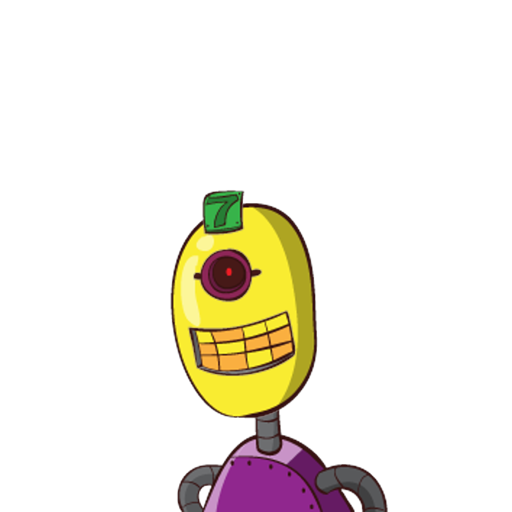

In [5]:
img_gen = ImageGenerator(robot_collection)
my_img = img_gen.generate("hamnghi", size=(512, 512), proportion=0.85)
my_img

In [6]:
img_gen._hash("test")

BitArray('0xee26b0dd4af7e749aa1a8ee3c10ae9923f618980772e473f8819a5d4940e0db27ac185f8a0e1d5f84f88bc887fd67b143732c304cc5fa9ad8e6f57f50028a8ff')

## Generative Art for Background

In [7]:
from lxml import etree
from lxml.etree import Element

from delicacy.svglib.utils.utils import eprint, get_canvas, Size
from delicacy.svglib.utils.utils import svg2img, canvas2img

In [8]:
canvas = get_canvas(512, 512)

eprint(canvas)
print(canvas.attrib)

<svg xmlns:xlink="http://www.w3.org/1999/xlink" width="512" height="512" xmlns="http://www.w3.org/2000/svg"/>

{'width': '512', 'height': '512', 'xmlns': 'http://www.w3.org/2000/svg'}


### Style

In [9]:
from delicacy.svglib.style import Style, Stroke, Fill

stroke, fill = Stroke(), Fill()
print(stroke)
print(fill)

stroke: black; stroke-opacity: 1; stroke-width: 1;
fill: black; fill-opacity: 1;


### SVGLib

In [10]:
from delicacy.svglib.elements.element import SVGElement, ExtendedElement, svg_define

style_str = 'stroke: black;stroke-opacity: 1;\nfill-opacity: 1;stroke-width: 1;fill: black;'
ExtendedElement.extract_styles(style_str)

{'stroke': 'black',
 'stroke-opacity': '1',
 'fill-opacity': '1',
 'stroke-width': '1',
 'fill': 'black'}

In [11]:
from delicacy.svglib.point import Point, rand_bounded_points, rand_fixed_points, rand_points
from delicacy.svglib.utils.chain import chainable

In [12]:
from delicacy.svglib.transform import Transform
Transform().translate(5).skewX(4)()

'translate(5,0) skewX(4)'

In [13]:
from delicacy.svglib.elements.shapes import Line, Polygon, Circle, Rectangle, Path, XShape, ETriangle

line = Line.make_line(0, 100, 200, 500)

line.add_transform(Transform().translate(4).rotate(45).scale(3))
line.apply_styles(Stroke(), Fill())

eprint(line()); line.styles

<line x1="0" y1="100" x2="200" y2="500" transform="translate(4,0) rotate(45) scale(3,3)" style="stroke: black; stroke-opacity: 1; stroke-width: 1; fill: black; fill-opacity: 1;"/>



{'stroke': 'black',
 'stroke-opacity': '1',
 'stroke-width': '1',
 'fill': 'black',
 'fill-opacity': '1'}

In [14]:
from delicacy.svglib.colors.hsv import HSVColor
from delicacy.svglib.colors.palette import PaletteGenerator
from delicacy.svglib.colors.palette import (
    analogous,
    monochromatic,
    shade,
    tint,
    complementary,
    triad,
    square,
    jewel,
    pastel,
    earth,
    neon,
    palettes
)

In [15]:
from delicacy.svglib.colors.rgb import RGBColor

def lerp(start: RGBColor, end: RGBColor, mix: float = 0) -> RGBColor:
    if mix < 0 or mix > 1:
        raise ValueError("mix must be in range: [0, 1]")
    rgb_it = (int(abs(s - e) * mix) + min(s, e) for s, e in zip(start, end))
    return RGBColor.from_iterable(rgb_it)


def lerp_gradient(start: RGBColor, end: RGBColor, k: int = 10):
    return (lerp(start, end, i / k) for i in range(k))

In [16]:
def create_line(
    start: Point,
    stop: Point,
    color: RGBColor,
    width: int,
    *args: str,
    **kwds: str
) -> Line:
    stroke = Stroke(color.to_hex(), width=width, *args, **kwds)
    line = Line(start, stop)
    line.set_style(stroke)
    return line


def pixelgami(
    size: Optional[Size] = None,
    num: int = 20,
    scale: float = 0.2,
    offset: int = 0,
    color_style="pastel",
):
    size = Size(512, 512) if size is None else Size(*size)
    canvas = get_canvas(*size)

    points = rand_fixed_points(
        num,
        (0 + offset, size.width - offset),
        (0 + offset, size.height - offset),
    )
    palette = lerp_gradient(
        RGBColor.randcolor(color_style),
        RGBColor.randcolor(color_style),
        num,
    )

    start_points, end_points = tee(points)
    origin = next(end_points)

    for i, (start, end, color) in enumerate(
        zip(start_points, end_points, palette), 1
    ):
        width = i * scale
        line = create_line(start, end, color, width)
        canvas.append(line())
    else:
        color = next(palette)
        width = (i + 1) * scale
        end_line = create_line(end, origin, color, width)
        canvas.append(end_line())

    return canvas

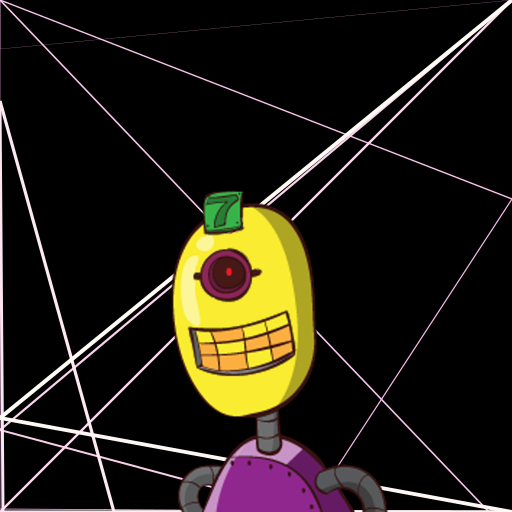

In [17]:
pxgm = pixelgami()
bg_img = canvas2img(pxgm)
bg_img.paste(my_img, (0, 0), my_img)
bg_img

In [18]:
from delicacy.svglib.utils.utils import linspace

In [19]:
from functools import partial
from typing import Union


def wraps(
    tag,
    *childs: Union[etree._Element, SVGElement],
    extended: bool = True,
    **kwds
) -> SVGElement:
    root = etree.Element(tag, **kwds)
    try:
        root.extend(childs)
    except TypeError:
        root.extend(child() for child in childs)

    element_cls = ExtendedElement if extended else SVGElement
    return element_cls.from_etree_element(root)


defs = partial(wraps, "defs")

In [20]:
from attrs.validators import in_
from lxml.etree import SubElement


@svg_define(init=False)
class BaseGradient(SVGElement):
    id: str
    spreadMethod: str = field(
        default="pad", validator=in_(("pad", "repeat", "reflect"))
    )

    def add_stop(self, offset: float, color: str, opacity: float) -> None:
        if not 0 <= offset <= 1:
            raise ValueError(f"offset: {offset} not in range: [0, 1]")

        attributes = {
            "offset": f"{offset:.0%}",
            "stop-color": color,
            "stop-opacity": str(float(opacity)),
        }

        se = SubElement(self(), "stop", **attributes)

    @classmethod
    def create_gradient(cls, colors, *args, **kwds):
        n_colors = len(colors)
        gradient = cls(*args, **kwds)

        for color, offset in zip(colors, linspace(0, 1, n_colors)):
            gradient.add_stop(offset, color, 1)

        return gradient

In [21]:
@svg_define
class LinearGradient(BaseGradient):
    id: str = "linearGradient"
    start: tuple[float, float] = field(default=(0, 0))
    stop: tuple[float, float] = field(default=(1, 1))

    def __attrs_post_init__(self) -> None:
        tags = ["x1", "y1", "x2", "y2"]
        start = (f"{i:.0%}" for i in self.start)
        stop = (f"{i:.0%}" for i in self.stop)

        lg = Element("linearGradient")
        lg.set("id", str(self.id))

        for attr, val in zip(tags, chain(start, stop)):
            lg.set(attr, val)

        lg.set("spreadMethod", self.spreadMethod)
        self._element = lg

In [22]:
@svg_define
class RadialGradient(BaseGradient):
    radius: float = 0.55
    id: str = "radialGradient"
    center: tuple[float, float] = field(default=(0.5, 0.5))
    focus: tuple[float, float] = field(default=(0.5, 0.5))

    def __attrs_post_init__(self) -> None:
        tags = ["cx", "cy", "fx", "fy"]
        center = (f"{i:.0%}" for i in self.center)
        focus = (f"{i:.0%}" for i in self.focus)

        rg = Element("radialGradient")
        rg.set("id", str(self.id))
        rg.set("r", f"{self.radius:.0%}")

        for attr, val in zip(tags, chain(center, focus)):
            rg.set(attr, val)

        rg.set("spreadMethod", self.spreadMethod)
        self._element = rg

In [23]:
rg = RadialGradient.create_gradient(
    colors=["#e63946", "#e0aaff", "#240046", "#1d3557"]
)

print(defs(rg))

<defs>
  <radialGradient id="radialGradient" r="55%" cx="50%" cy="50%" fx="50%" fy="50%" spreadMethod="pad">
    <stop offset="0%" stop-color="#e63946" stop-opacity="1.0"/>
    <stop offset="33%" stop-color="#e0aaff" stop-opacity="1.0"/>
    <stop offset="67%" stop-color="#240046" stop-opacity="1.0"/>
    <stop offset="100%" stop-color="#1d3557" stop-opacity="1.0"/>
  </radialGradient>
</defs>



In [24]:
def get_reference(element):
    return f"url(#{element.id})"


get_reference(rg)

'url(#radialGradient)'

In [25]:
def karafuru(
    size: Optional[Size] = None,
    n_points: int = 50,
    colors=None,
    n_colors: int = 2,
    gradient_type: str = "linear",
    color_style: str = "neon",
):
    size = Size(512, 512) if size is None else Size(*size)
    canvas = get_canvas(*size)

    if colors is None:
        colors = tuple(
            RGBColor.randcolor(color_style).to_hex() for _ in range(n_colors)
        )

    if gradient_type not in ["linear", "radial"]:
        raise ValueError('gradient_type can only be ["linear", "radial"]')

    gradient = LinearGradient if gradient_type == "linear" else RadialGradient
    gradient = gradient.create_gradient(colors, spreadMethod="reflect")
    defs_gradient = defs(gradient)

    points = rand_fixed_points(n_points, (0, size.width), (0, size.height))
    stroke = Stroke(color=get_reference(gradient), width=2, opacity=1)

    polygon = Polygon(points)
    polygon.set_style(stroke)

    canvas.append(defs_gradient())
    canvas.append(polygon())

    return canvas

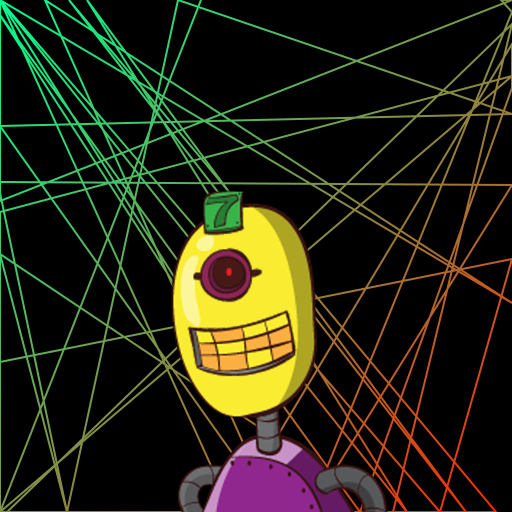

In [26]:
krfr = karafuru(n_colors=2, gradient_type="linear")
bg_img = canvas2img(krfr)
bg_img.paste(my_img, (0, 0), my_img)
bg_img

In [27]:
eprint(krfr)

<svg xmlns:xlink="http://www.w3.org/1999/xlink" width="512" height="512" xmlns="http://www.w3.org/2000/svg">
  <defs>
    <linearGradient id="linearGradient" x1="0%" y1="0%" x2="100%" y2="100%" spreadMethod="reflect">
      <stop offset="0%" stop-color="#00ff8f" stop-opacity="1.0"/>
      <stop offset="100%" stop-color="#ff2700" stop-opacity="1.0"/>
    </linearGradient>
  </defs>
  <polygon points="0,512 201,0 0,512 0,260 0,512 512,76 0,212 0,512 0,512 0,512 496,512 69,0 466,512 87,0 407,512 0,0 232,512 512,44 512,88 360,512 0,15 322,512 0,0 0,182 512,185 309,512 512,12 501,0 512,0 0,201 0,6 0,193 67,512 0,254 386,512 358,512 393,512 512,24 7,512 67,512 178,0 512,114 0,126 274,512 45,0 512,303 0,0 440,512 512,259 0,362" style="stroke: url(#linearGradient); stroke-opacity: 1; stroke-width: 2;"/>
</svg>



In [213]:
from random import choice, randint


def randspace(start, stop, n_samples):
    return sorted(set(randint(start, stop) for _ in range(n_samples)))


def teikoku(
    size: Optional[Size] = None,
    x_density: int = 6,
    y_density: int = 45,
    n_colors: int = 5,
    palette_func = None
):
    size = Size(512, 512) if size is None else Size(*size)
    canvas = get_canvas(*size)
    
    if palette_func is None:
        palette_func = random.choice((pastel, neon))
        
    colors = PaletteGenerator(palette_func).generate(num=n_colors)
    
    # colors = tuple(RGBColor.randcolor(color_style) for _ in range(n_colors))

    for yi in linspace(0, size.height, y_density):

        n_lines = randint(1, x_density)
        chunks = randspace(0, size.width, n_lines * 2)

        for i in range(0, len(chunks), 2):
            try:
                startx, endx = chunks[i], chunks[i + 1]
            except IndexError:
                continue
            else:
                line = create_line(
                    start=Point(startx, yi),
                    stop=Point(endx, yi),
                    color=choice(colors),
                    width=5,
                    linecap="round",
                )
                canvas.append(line())
    return canvas

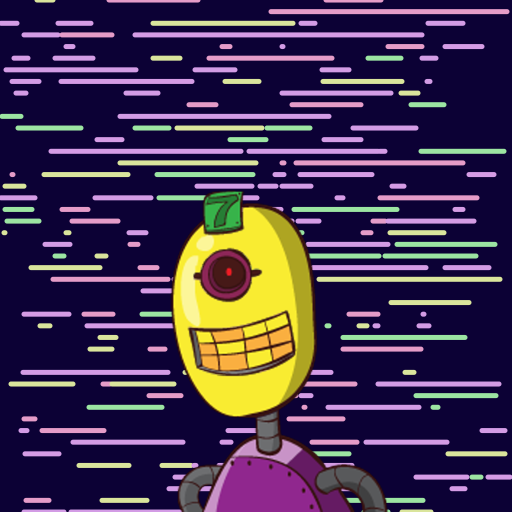

In [269]:
tkk = teikoku()
bg_img = canvas2img(tkk, bg_color="#0c0135")
bg_img.paste(my_img, (0, 0), my_img)
bg_img

In [71]:
from random import choice

# https://github.com/hogesonline/svg_play/blob/master/maze_for_web.py
def meiro(
    size: Optional[Size] = None,
    color: Optional[str] = None,
    num: int = 30,
    color_style: str = "pastel",
    randwidth: bool = False,
):
    if color is None:
        color = RGBColor.randcolor(color_style)
    else:
        color = RGBColor.from_hex(color)

    size = Size(512, 512) if size is None else Size(*size)
    canvas = get_canvas(*size)
    step = size.height // num

    for x in range(0, size.width, step):
        for y in range(0, size.height, step):
            width = randint(1, 3) if randwidth else 2
            if choice([True, False]):
                start, stop = Point(x, y), Point(x + step, y + step)
            else:
                start, stop = Point(x + step, y), Point(x, y + step)
            line = create_line(start, stop, color, width)
            canvas.append(line())
    return canvas

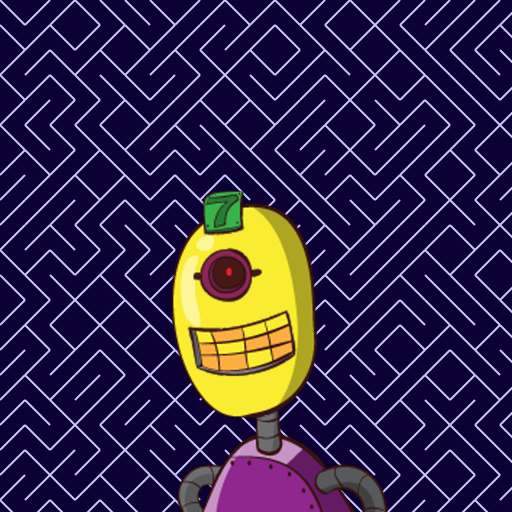

In [31]:
mr = meiro(num=20)
# eprint(mz)
bg_img = canvas2img(mr, bg_color="#0c0135")
bg_img.paste(my_img, (0, 0), my_img)
bg_img

In [32]:
from itertools import compress

# https://www.geeksforgeeks.org/sieve-of-eratosthenes/
def sieve_of_eratosthenes(n):
    is_prime = [True for _ in range(n + 1)]
    p = 2

    while p * p <= n:
        if is_prime[p]:
            for i in range(p * p, n, p):
                is_prime[i] = False
        p += 1
    return is_prime


def primes_upto(n: int):
    result = compress(range(n), sieve_of_eratosthenes(n))
    return tuple(result)

In [177]:
def mondrian(
    size: Optional[Size] = None,
    y_density: int = 125,
    n_colors: Optional[int] = None,
    palette_func = None,
):
    size = Size(512, 512) if size is None else Size(*size)
    canvas = get_canvas(*size)

    if n_colors is None:
        colors = ("#f7352f", "#017bfc", "#fad000", "black", "white")
    else:
        if palette_func is None:
            palette_func = random.choice([neon, analogous, tint, shade])
        colors = PaletteGenerator(palette_func).generate(n_colors)
        colors = [c.to_hex() for c in colors]
        colors += ["black", "white"]

    levels = linspace(0, size.height, y_density)

    for y in levels:
        x = 0
        try:
            height = next(levels)
        except StopIteration:
            break
        while x <= size.width:
            rect = Rectangle(
                location=Point(x, y),
                size=((x := x + randint(0, size.width)), height),
            )

            color = choice(colors)
            rect.apply_styles(Fill(color=color), Stroke(color, width=0))
            canvas.append(rect())

    return canvas

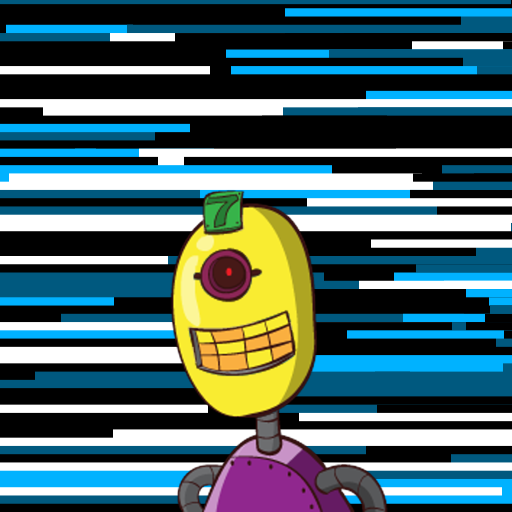

In [209]:
mdr = mondrian(n_colors=3)
bg_img = canvas2img(mdr)
bg_img.paste(my_img, (0, 0), my_img)
bg_img

In [35]:
eprint(canvas)

<svg xmlns:xlink="http://www.w3.org/1999/xlink" width="512" height="512" xmlns="http://www.w3.org/2000/svg"/>



In [36]:
def spiral_curve(n, scale=1, step=1):
    for i in range(0, n, step):
        yield (i, scale * radians(i))

In [37]:
# list(
#     Point.from_polar_radians(r, t)
#     for r, t in spiral_curve(360, scale=0.1, step=2)
# )

## SVG Path

In [38]:
from attrs import astuple


@svg_define
class Use(ExtendedElement):
    href: str
    location: Point = Point(0, 0)
    size: Optional[Size] = None

    def __attrs_post_init__(self) -> None:


        self.href = "#" + self.href

        tags = "href x y".split()
        values = (str(v) for v in (self.href, *self.location))

        if self.size is not None:
            tags += ["width", "height"]
            values = chain(values, (str(i) for i in self.size))

        self._element = Element("use", **dict(zip(tags, values)))

In [39]:
use = Use("something")
str(use)

'<use href="#something" x="0" y="0"/>\n'

In [40]:
from functools import partial

defs = partial(wraps, "defs")
group = partial(wraps, "g")
symbol = partial(wraps, "symbol")

In [41]:
from math import atan
from itertools import chain


def _rotate(theta: float) -> tuple[float, ...]:
    theta = radians(theta)
    return (cos(theta), sin(theta), -sin(theta), cos(theta))


def _relocate(
    start_x: float, start_y: float, theta: float
) -> tuple[float, ...]:
    x, y = start_x, -start_y
    r = hypot(x, y)

    theta = radians(-theta)
    beta = atan(y / x)
    alpha = theta + beta

    l, k = cos(alpha) * r, sin(alpha) * r
    return x - l, k - y


def _self_rotate(
    start_x: float, start_y: float, theta: float
) -> tuple[float, ...]:
    rotation = _rotate(theta)
    relocation = _relocate(start_x, start_y, theta)
    return tuple(chain(rotation, relocation))

In [42]:
RGBColor(255, 255, 255).to_hex()

'#ffffff'

In [43]:
from math import sin, radians
from functools import partial


def fade(
    element: ExtendedElement,
    location: Point = Point(0, 0),
    color: Optional[str] = None,
    scale: Optional[float] = None,
    rotate: Optional[float] = None,
    spread: tuple[int, int] = (20, 25),
    fading_scale: float = 0.7,
    k: int = 3,
) -> ExtendedElement:

    if color is None:
        color = RGBColor.randcolor("pastel").to_hex()

    if scale is None:
        scale = random.randint(5, 25) / 100

    if rotate is None:
        rotate = random.randint(0, 360)

    eid = str(id(element))
    defs_element = defs(group(element, id=eid))

    uses = []
    origin = (0, 0)
    direction = random.choices([-1, 1], k=2)
    width, opacity = 25, 1

    for i in range(k):
        distance = random.choices(range(*spread), k=2)
        new_location = (
            (i * dis * drc) + loc
            for dis, drc, loc in zip(distance, direction, origin)
        )

        use = Use(href=eid, location=new_location)
        use.apply_styles(Stroke(color, opacity, width), Fill(color="none"))

        width *= fading_scale
        opacity *= fading_scale

        uses.append(use)

    _fade = group(defs_element, *uses)
    transform = Transform().translate(*location).scale(scale).rotate(rotate)
    _fade.add_transform(transform)

    return _fade

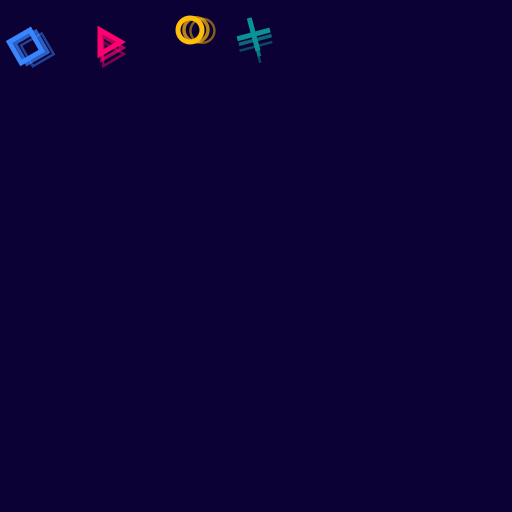

In [44]:
canvas = get_canvas(512, 512)

side = 120

colors = ["#3a86ff", "#ff006e", "#ffbe0b", "#0a9396"]

rec = Rectangle(Point(0, 0), Size(side, side))
frec = fade(
    rec, location=Point(30, 30), color="#3a86ff", scale=0.2, rotate=60
)
canvas.append(frec())


tri = ETriangle(side=side)
ftri = fade(
    tri, location=Point(100, 30), color="#ff006e", scale=0.2, rotate=30
)
canvas.append(ftri())


cir = Circle(side // 2)
fcir = fade(cir, location=Point(190, 30), color="#ffbe0b", scale=0.2)
canvas.append(fcir())


x = XShape(length=side)
fx = fade(x, location=Point(270, 30), color="#0a9396", scale=0.2, rotate=120)
canvas.append(fx())

# eprint(canvas)

bg_img = canvas2img(canvas, bg_color="#0c0135")
bg_img

In [45]:
random.choices(range(50, 460), k=2)

[364, 381]

In [46]:
"""#f35f3b
#fec268
#FFEDD1
#5af9c3
#00f596
""".splitlines()

['#f35f3b', '#fec268', '#FFEDD1', '#5af9c3', '#00f596']

In [47]:
colors1 = [RGBColor.randcolor("pastel").to_hex() for _ in range(7)]
colors2 = ["#8d43ad", "#cc43c9", "#e644aa", "#f74c78", "#f49683", "#f2d69d"]
colors3 = ["#3a86ff", "#ff006e", "#ffbe0b", "#0a9396"]
colors4 = ["#6e2f74", "#872b73", "#a0256f", "#b62066", "#c9205b", "#d8284c"]
colors5 = ['#f35f3b', '#fec268', '#FFEDD1', '#5af9c3', '#00f596']
colors6 = ['#070707', '#4367c1', '#080c14', '#09183d', '#0b2872']
colors7 = ['#e8907d', '#592c22', '#e03b16', '#fcd9d1', '#7c3424']

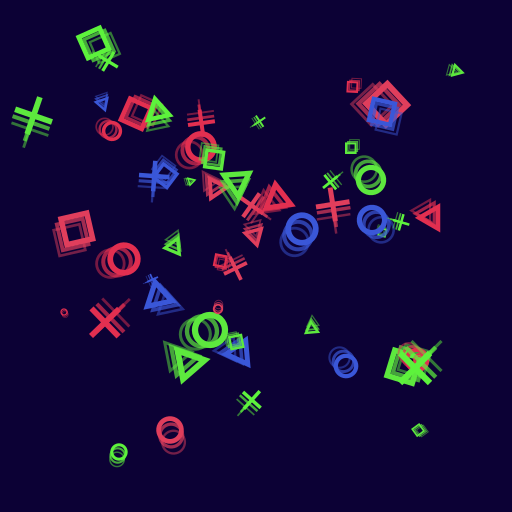

In [279]:
canvas = get_canvas(512, 512)

side = 120
y_axis = 30

# colors = random.choice([colors1, colors2, colors3, colors4])
palette_func = random.choice(tuple(palettes))
colors = [color.to_hex() for color in PaletteGenerator(palette_func).generate()]


for y_axis in range(50, 512, 35):
    #     x_axis = range(50, 512, 120)

    rec = Rectangle(Point(0, 0), Size(side, side))
    frec = fade(
        rec,
        location=random.choices(range(50, 460), k=2),
        color=random.choice(colors),
    )
    canvas.append(frec())

    tri = ETriangle(side=side)
    ftri = fade(
        tri,
        location=random.choices(range(50, 460), k=2),
        color=random.choice(colors),
    )
    canvas.append(ftri())

    cir = Circle(side // 2)
    fcir = fade(
        cir,
        location=random.choices(range(50, 460), k=2),
        color=random.choice(colors),
    )
    canvas.append(fcir())

    x = XShape(length=side)
    fx = fade(
        x,
        location=random.choices(range(50, 460), k=2),
        color=random.choice(colors),
    )
    canvas.append(fx())

# eprint(canvas)

bg_img = canvas2img(canvas, bg_color="#0c0135")
bg_img

In [49]:
from itertools import product

In [50]:
list(product([shade,tint],range(3)))

[(<function delicacy.svglib.colors.palette.shade(num: int) -> Iterator[delicacy.svglib.colors.hsv.HSVColor]>,
  0),
 (<function delicacy.svglib.colors.palette.shade(num: int) -> Iterator[delicacy.svglib.colors.hsv.HSVColor]>,
  1),
 (<function delicacy.svglib.colors.palette.shade(num: int) -> Iterator[delicacy.svglib.colors.hsv.HSVColor]>,
  2),
 (<function delicacy.svglib.colors.palette.tint(num: int) -> Iterator[delicacy.svglib.colors.hsv.HSVColor]>,
  0),
 (<function delicacy.svglib.colors.palette.tint(num: int) -> Iterator[delicacy.svglib.colors.hsv.HSVColor]>,
  1),
 (<function delicacy.svglib.colors.palette.tint(num: int) -> Iterator[delicacy.svglib.colors.hsv.HSVColor]>,
  2)]